### Setting up the Python enviroment
In this part we import the required libraries for the tutorial. The script requires Gempy as well as Numpy and Matplotlib. We configure a Jupyter option for the interactive representation of Matplotlib graphics after the script cells (%matplotlib inline). <br/>
Notice the that warnings are only messages that the user have to take in mind when running the script, they do not mean a failure of the code. Since this tutorial is on Windows some complementary libraries were unable to install but the overall performance of the geological modeling code is complete.

In [2]:
# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing GemPy
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

### Creation of the geological model object and statigraphy definition
The tutorial creates a grid of 100 col x 100 rows x 100 layers over a extension of 2km x 2km x 2km. Higher resolutions are posible but the computational time will be higher. The coordinate system is of local coordinates, comming tutorial will evaluate the performace of Gempy with UTM coordinates. <br/>
The orientation and geological contacts are imported from CSV files and converted into a Pandas dataframe. Then the geological series (faults / formations) are defined as well as the geological formation sequence. <br/>
Its important to mentions that faults have to be inserted independently, where the youngest is the first entry.

In [3]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[100,100,100],
                          path_o = "../Txt/simple_fault_model_orientations.csv", # importing orientation (foliation) data
                          path_i = "../Txt/simple_fault_model_points.csv") # importing point-positional interface data

In [4]:
gp.get_data(geo_data).loc[:,['X','Y','Z','formation']].head()

X       Y       Z   formation
interfaces 52  700.0  1000.0   900.0  Main_Fault
           53  600.0  1000.0   600.0  Main_Fault
           54  500.0  1000.0   300.0  Main_Fault
           55  800.0  1000.0  1200.0  Main_Fault
           56  900.0  1000.0  1500.0  Main_Fault

In [5]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"Fault_Series":'Main_Fault',
                      "Strat_Series": ('Sandstone_2','Siltstone', 'Shale', 'Sandstone_1')},
                       order_series = ["Fault_Series", 'Strat_Series'],
                       order_formations=['Main_Fault',
                                         'Sandstone_2','Siltstone', 'Shale', 'Sandstone_1',
                                         ], verbose=0)


### Geological sequence plot
Gempy has some useful features to represent the defined geological series and formation sequences.

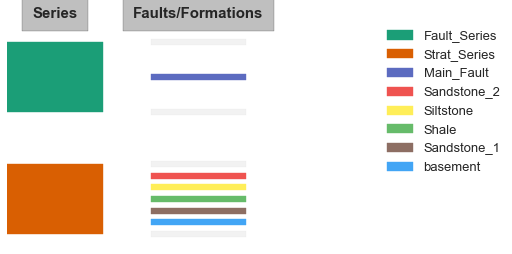

In [6]:
gp.get_sequential_pile(geo_data)

### Review of the input data
The different datasets for the geological model construction can be accessed though the ".get_" functions of Gempy.

In [7]:
# Review of the centroid coordinates from the model grid
gp.get_grid(geo_data).values

array([[   10.,    10.,    10.],
       [   10.,    10.,    30.],
       [   10.,    10.,    50.],
       ..., 
       [ 1990.,  1990.,  1950.],
       [ 1990.,  1990.,  1970.],
       [ 1990.,  1990.,  1990.]], dtype=float32)

In [9]:
# Defined interfases from the input CSV data
gp.get_data(geo_data, 'interfaces').loc[:,['X','Y','Z','formation']].head()

,X,Y,Z,formation
52,700.0,1000.0,900.0,Main_Fault
53,600.0,1000.0,600.0,Main_Fault
54,500.0,1000.0,300.0,Main_Fault
55,800.0,1000.0,1200.0,Main_Fault
56,900.0,1000.0,1500.0,Main_Fault


In [11]:
# Defined layer orientations from the input CSV data
gp.get_data(geo_data, 'orientations').loc[:,['X','Y','Z','formation','azimuth']]

,X,Y,Z,formation,azimuth
2,500,1000,864.602,Main_Fault,270
1,400,1000,1400.000,Sandstone_2,90
0,1000,1000,950.000,Shale,90


### Graphical representation of input data
In this part 2D and 3D representations were done to present the interfases and orientations.

E:\Software\Anaconda3\lib\site-packages\gempy\gempy_front.py:927: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  warnings.warn("gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead", FutureWarning)


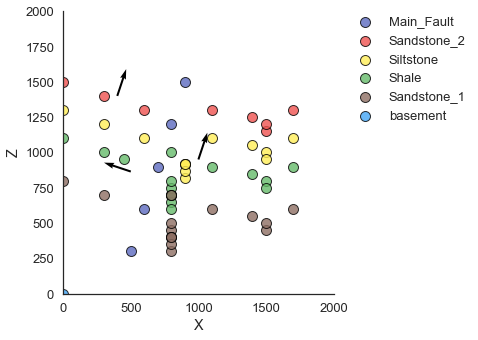

In [12]:
gp.plot_data(geo_data, direction='y')

In [13]:
gp.plotting.plot_data_3D(geo_data)

### Geological interpolation
Once the input data is ready, we can define the data and parameters for the interpolation with the InterpolatonData method from the Gempy library. <br/>
The geological model is calculated under the "compute_model" method. Results from the model process are the lithology and faults on the same array dimensions as the geo_data.

In [14]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


In [15]:
interp_data.geo_data_res.formations.as_matrix

<bound method NDFrame.as_matrix of              value  formation_number
Main_Fault       1                 1
Sandstone_2      2                 2
Siltstone        3                 3
Shale            4                 4
Sandstone_1      5                 5
basement         6                 6>

In [16]:
interp_data.geo_data_res.get_formations()

[Main_Fault, Sandstone_2, Siltstone, Shale, Sandstone_1]
Categories (5, object): [Main_Fault, Sandstone_2, Siltstone, Shale, Sandstone_1]

In [17]:
lith_block, fault_block = gp.compute_model(interp_data)

### Lithologic model exploration
The lithology block has two parts, the first one has information about the lithological formation, while the second represents the orientation. In this part the distribution of lithology and fault-separated information are represented as histograms.

In [18]:
lith_block[0]

array([ 6.3131361 ,  6.24877167,  6.19397354, ...,  2.00398016,
        2.00626612,  2.00983   ], dtype=float32)

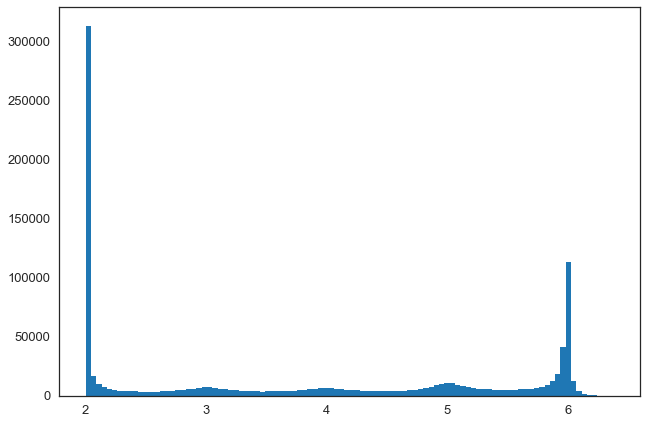

In [19]:
plt.hist(lith_block[0],bins=100)
plt.show()

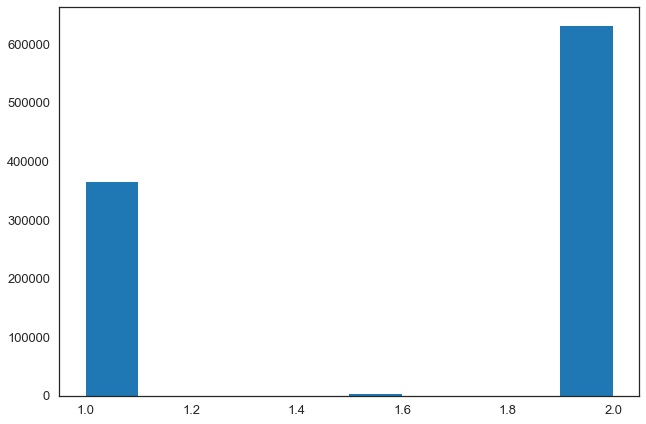

In [20]:
plt.hist(fault_block[0],bins=10)
plt.show()

### Geological model representation

As any other Numpy array, the resulting lithological blocks can be represented on Matplotlib. However, Gempy have special methods for cross section representation. With the use of Jupyter widgets an interactive representation of the geological cross sections along the Y direction is performed with a handelbar to shift along rows.

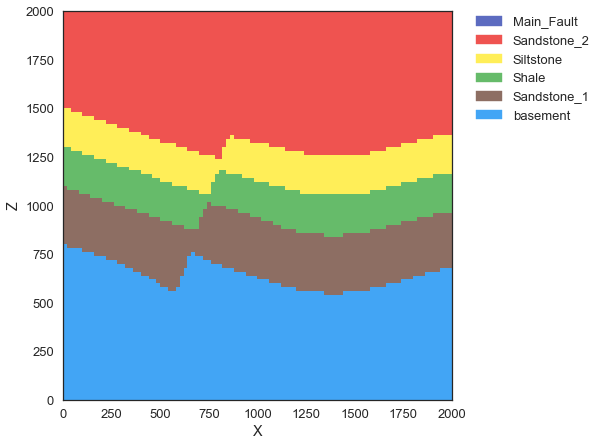

In [21]:
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=50,  direction='y', plot_data=False)

In [22]:
import ipywidgets as widgets

def plotCrossSection(cell):
    gp.plotting.plot_section(geo_data, lith_block[0], cell_number=cell,  direction='y', plot_data=False)
    

widgets.interact(plotCrossSection, cell=widgets.IntSlider(min=0,max=99,step=1,value=50) )

interactive(children=(IntSlider(value=50, description='cell', max=99), Output()), _dom_classes=('widget-interact',))

<function __main__.plotCrossSection>

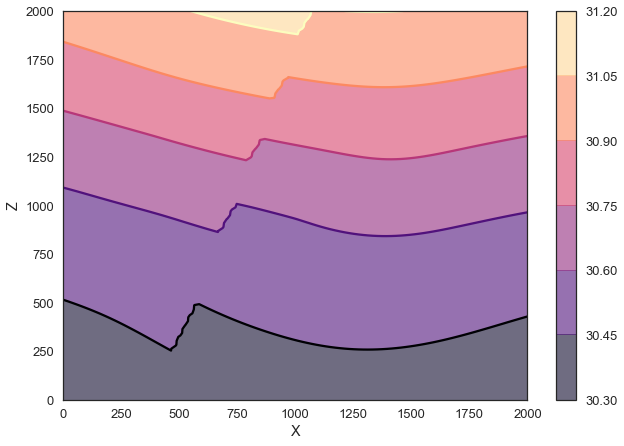

In [23]:
gp.plotting.plot_scalar_field(geo_data, lith_block[1], cell_number=50, N=6,
                        direction='y', plot_data=False)
plt.colorbar()
plt.show()

In [24]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1],
                               fault_block[1],
                               original_scale=True)

In [25]:
gp.plotting.plot_surfaces_3D(geo_data, ver_s, sim_s)